In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
df = pd.read_csv('./data/alturas-pesos-mils-train.csv')

In [3]:
data = df[['Altura', 'Peso']].values

# Regresión Lineal
con todo el dataset

In [4]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(data[:,0].reshape(-1,1), data[:,1])
w_LR = np.array([clf.intercept_, clf.coef_[0]]).reshape(2,1)
print(w_LR)

[[-158.41934476]
 [   1.37539177]]


# Regresión Polinomial
De a N ejemplos

In [5]:
def get_pol(data, order=1, normalize=True, mean = 0, std = 1):
    data_rep = np.repeat(data.reshape(-1,1), order+1, axis=1)
    exps = [i for i in range(order+1)]
    data_all = np.power(data_rep, exps)
    if normalize:
        mean = data_all.mean(axis=0)[1:]
        std = data_all.std(axis=0)[1:]
        data_all[:, 1:] = data_all[:, 1:] - data_all.mean(axis=0)[1:]
        data_all[:, 1:] = data_all[:, 1:]/data_all.std(axis=0)[1:]
        return data_all, mean, std
    else:
        data_all[:, 1:] = data_all[:, 1:] - mean
        data_all[:, 1:] = data_all[:, 1:]/std
        return data_all

In [80]:
def get_ridge_weights(alturas, pesos, lamb = 0.1):
    ident = np.matrix(np.identity(alturas.shape[1]))
    X = np.matrix(alturas)
    y = np.matrix(pesos).T
    wRR = (lamb*ident + X.T*X)**-1*X.T*y
    return wRR

In [75]:
N=20
i=0
get_ridge_weights(alturas_pol[i*N:(i+1)*N], data[:,1][i*N:(i+1)*N], lamb = 1)

(4, 4)


matrix([[68.76671614],
        [ 4.11510708],
        [ 4.16583453],
        [ 4.24767583]])

In [65]:
def get_weights(alturas_pol, pesos, order = 3, lamb = 0.1, N = 20):
    ident = np.matrix(np.identity(order+1))
    WMLs = []
    WRRs = []
    for i in range(int(np.floor(len(df)/N))):
        X = np.matrix(alturas_pol[i*N:(i+1)*N])
        y = np.matrix(pesos[i*N:(i+1)*N]).T
        wML = ((X.T.dot(X))**-1*X.T)*y
        WMLs = WMLs + [wML.tolist()]
        wRR = (lamb*ident + X.T*X)**-1*X.T*y
        WRRs = WRRs + [wRR.tolist()]
        #print(i, len(y))
    WMLs = np.array(WMLs).reshape(-1,order+1)
    WRRs = np.array(WRRs).reshape(-1,order+1)
    return WMLs, WRRs

In [73]:
order = 3
N=20
lamb = 1
alturas_pol, mean, std = get_pol(data[:,0], order, normalize=True)
WMLs, WRRs = get_weights(alturas_pol, data[:,1], order = order, lamb = lamb, N = N)

In [8]:
def plt_lin_reg_gauss(alturas, pesos, Xmin, Xmax, Ymin, Ymax, order, mean, std, points = 100, ax=None):
    X = np.linspace(Xmin, Xmax, points)
    Y = np.linspace(Ymin, Ymax, points)
    X, Y = np.meshgrid(X, Y)
    Xr = X.reshape(-1)
    Yr = Y.reshape(-1)
    Y_est = get_pol(Xr, order, normalize=False, mean=mean, std=std).dot(WMLs[i])
    Z = norm.pdf(Yr - Y_est, 0, sigma).reshape(points, points)
    Z_points = norm.pdf(pesos - get_pol(alturas, order, normalize=False, mean=mean, std=std).dot(WMLs[i]),0 , sigma)
    if ax is None:
        fig = plt.figure(figsize=(20,10))
        ax = fig.gca(projection='3d')
    ax.contour3D(X, Y, Z, 512)
    ax.scatter3D(alturas, pesos, Z_points, color='r', marker='o')
    ax.view_init(65,-120)
    plt.show()

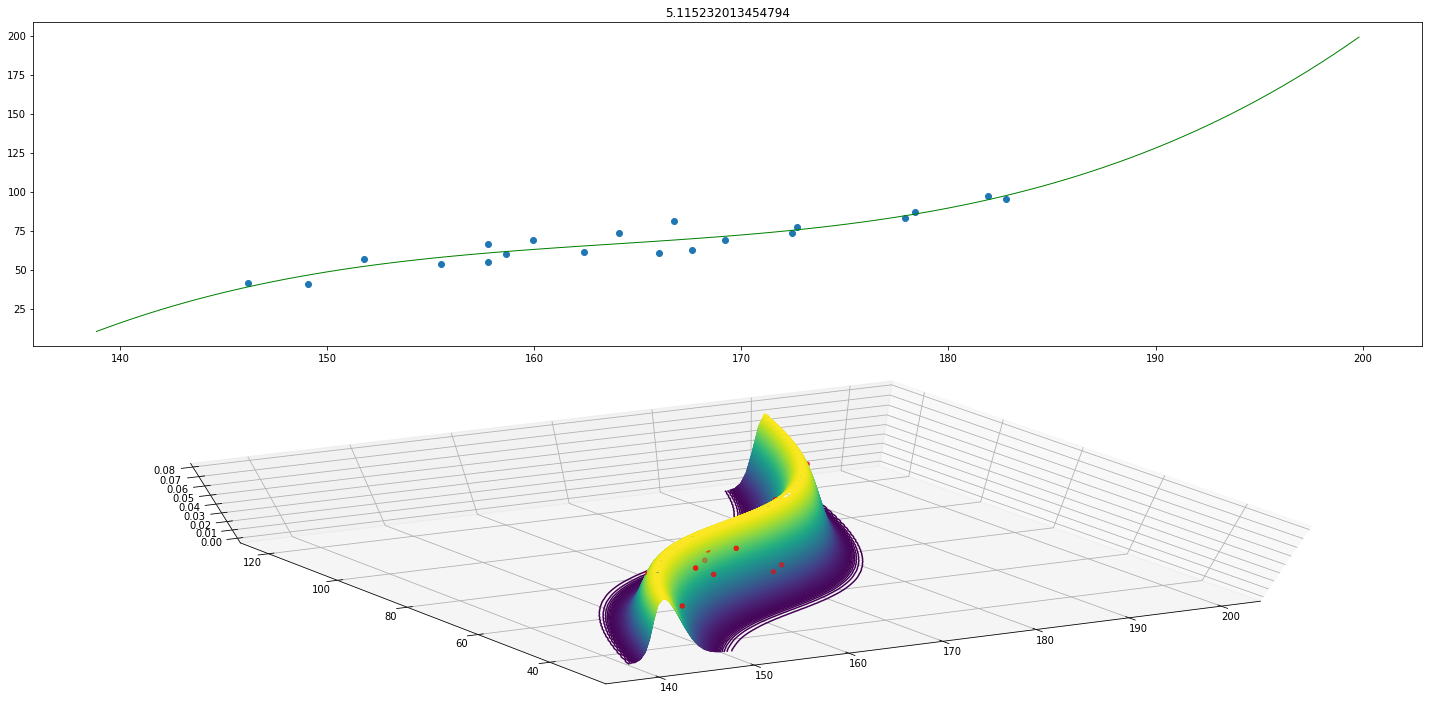

In [9]:
i = 0
al = np.linspace(data[:,0].min(),data[:,0].max(), 100)
alturas = data[i*N:(i+1)*N, 0]
pesos = data[i*N:(i+1)*N, 1]
fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(2, 1, 1)
ax1 = fig.add_subplot(2, 1, 2, projection='3d')
ax0.scatter(alturas, pesos)
sigma = (get_pol(alturas, order, normalize=False, mean=mean, std=std).dot(WMLs[i]) - pesos).std()
pe_MLE = get_pol(al, order, normalize=False, mean=mean, std=std).dot(WMLs[i])
ax0.plot(al, pe_MLE, 'g', lw=1)
ax0.set_title(str(sigma))
plt.tight_layout()
plt_lin_reg_gauss(alturas, pesos, data[:,0].min(),data[:,0].max(), data[:,1].min(),data[:,1].max(),order, mean, std, points = 100, ax=ax1)
plt.show()

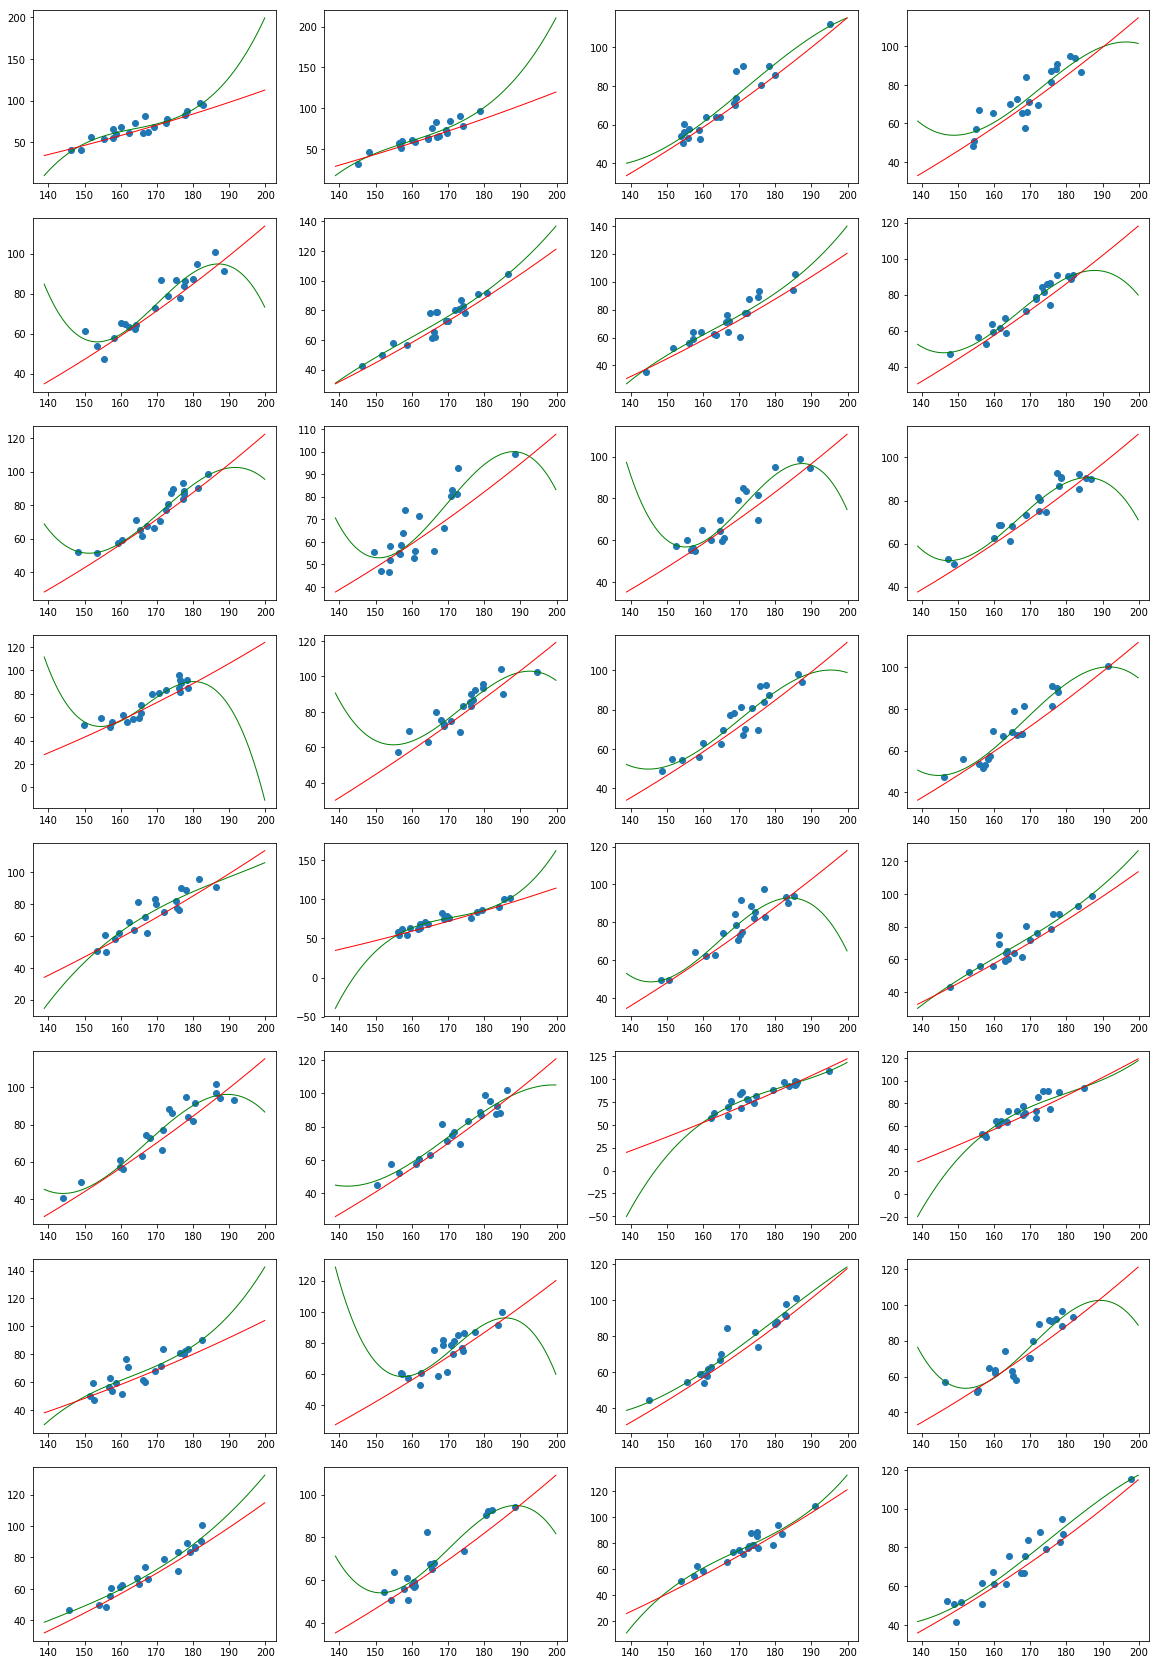

In [10]:
ptos = 100
f, ax = plt.subplots(8,4, figsize=(20,30))
ax = ax.reshape(-1)
al = np.linspace(data[:,0].min(),data[:,0].max(), ptos)
for i, w in enumerate(WMLs[:len(ax)]):
    ax[i].scatter(data[i*N:(i+1)*N, 0], data[i*N:(i+1)*N, 1])
    pe_MLE = get_pol(al, order, normalize=False, mean=mean, std=std).dot(w)

    pe_MAP = get_pol(al, order, normalize=False, mean=mean, std=std).dot(WRRs[i])
    ax[i].plot(al, pe_MLE, 'g', lw=1)
    ax[i].plot(al, pe_MAP, 'r', lw=1)
plt.show()

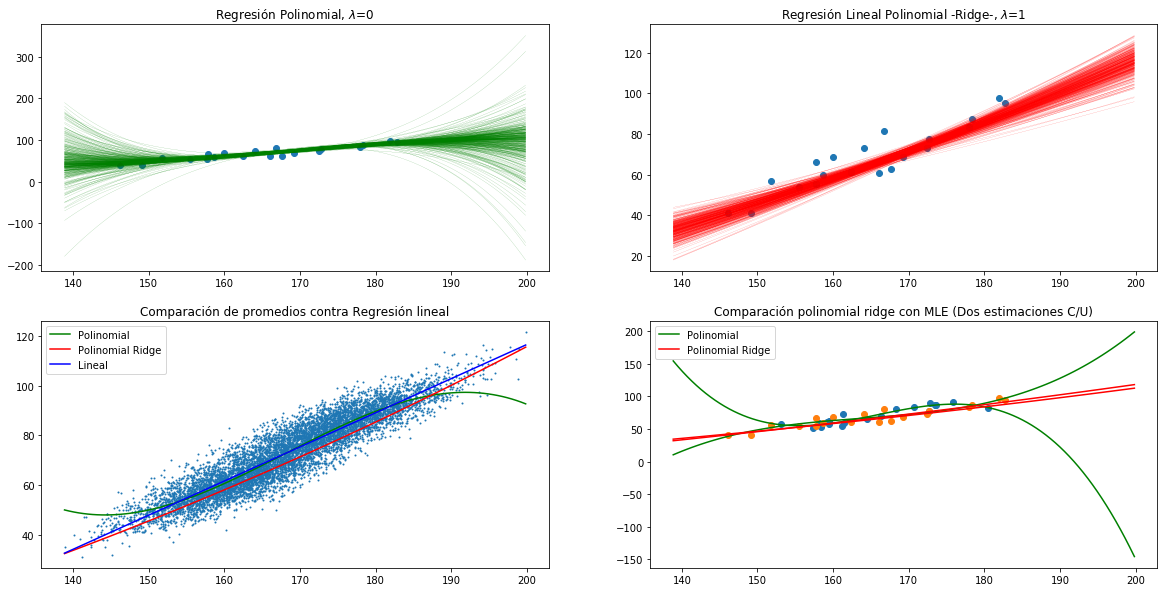

In [11]:
ptos = 100
f, ax = plt.subplots(2,2, figsize=(20,10))
al = np.linspace(data[:,0].min(),data[:,0].max(), ptos)
ax[0,0].scatter(data[:N,0], data[:N,1])
ax[1,0].scatter(data[:,0], data[:,1], s=1)
ax[0,1].scatter(data[:N,0], data[:N,1])
K1 = 40
K2=0
ax[1,1].scatter(data[K1*N:(K1+1)*N, 0], data[K1*N:(K1+1)*N, 1])
ax[1,1].scatter(data[K2*N:(K2+1)*N, 0], data[K2*N:(K2+1)*N, 1])
ax[0,0].set_title("Regresión Polinomial, $\lambda$=0")
ax[0,1].set_title("Regresión Lineal Polinomial -Ridge-, $\lambda$=" + str(lamb))
pe_MLE = get_pol(al, order, normalize=False, mean=mean, std=std).dot(WMLs.mean(axis=0))
pe_MAP = get_pol(al, order, normalize=False, mean=mean, std=std).dot(WRRs.mean(axis=0))
pe_LR = get_pol(al, normalize=False).dot(w_LR)
ax[1,0].plot(al, pe_MLE, 'g', label='Polinomial')
ax[1,0].plot(al, pe_MAP, 'r', label='Polinomial Ridge')
ax[1,0].plot(al, pe_LR, 'b', label='Lineal')
ax[1,0].legend()
ax[1,0].set_title("Comparación de promedios contra Regresión lineal")

ax[1,1].plot(al, get_pol(al, order, normalize=False, mean=mean, std=std).dot(WMLs[K1]), 'g', label='Polinomial')
ax[1,1].plot(al, get_pol(al, order, normalize=False, mean=mean, std=std).dot(WMLs[K2]), 'g')
ax[1,1].plot(al, get_pol(al, order, normalize=False, mean=mean, std=std).dot(WRRs[K1]), 'r', label='Polinomial Ridge')
ax[1,1].plot(al, get_pol(al, order, normalize=False, mean=mean, std=std).dot(WRRs[K2]), 'r')
ax[1,1].set_title("Comparación polinomial ridge con MLE (Dos estimaciones C/U)")
ax[1,1].legend()

curv_MLE = np.zeros([len(WMLs), ptos])
curv_MAP = np.zeros([len(WRRs), ptos])
for i, w in enumerate(WMLs):
    curv_MLE[i] = get_pol(al, order, normalize=False, mean=mean, std=std).dot(w)

for i, w in enumerate(WRRs):
    curv_MAP[i] = get_pol(al, order, normalize=False, mean=mean, std=std).dot(w)
    
ax[0,0].plot(al, curv_MLE.T, 'g', lw=0.1)
ax[0,1].plot(al, curv_MAP.T, 'r', lw=0.1)



plt.show()

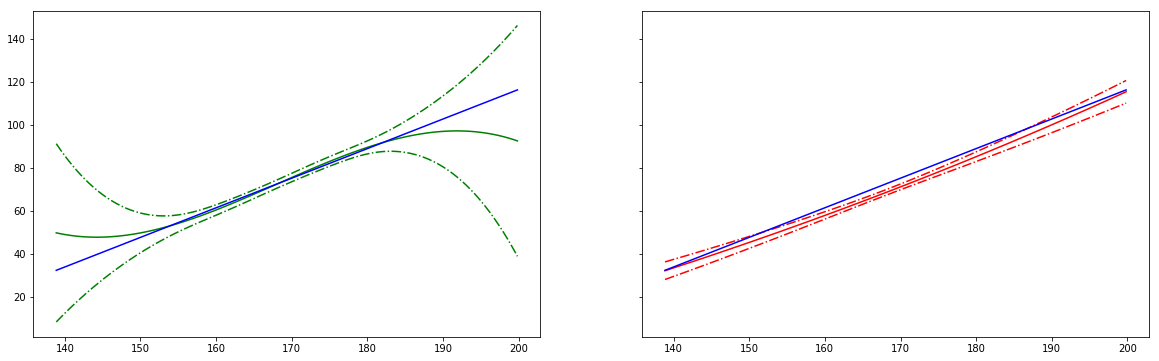

In [12]:
f, ax = plt.subplots(1,2, sharey=True, sharex=True, figsize=(20,6))
ax[0].plot(al, curv_MLE.mean(axis=0), 'g')
ax[0].plot(al, curv_MLE.mean(axis=0) + curv_MLE.std(axis=0), 'g', ls='-.')
ax[0].plot(al, curv_MLE.mean(axis=0) - curv_MLE.std(axis=0), 'g', ls='-.')
ax[0].plot(al, pe_LR, 'b', label='Lineal')
ax[1].plot(al, curv_MAP.mean(axis=0), 'r')
ax[1].plot(al, curv_MAP.mean(axis=0) + curv_MAP.std(axis=0), 'r', ls='-.')
ax[1].plot(al, curv_MAP.mean(axis=0) - curv_MAP.std(axis=0), 'r', ls='-.')
ax[1].plot(al, pe_LR, 'b', label='Lineal')
plt.show()

# Varianza y media de los pesos

In [15]:
print(WMLs.mean(axis=0))
print(WMLs.std(axis=0))
#print(WMLs.std(axis=0)/np.abs(WMLs.mean(axis=0)))
print(WMLs.var(axis=0)/(WMLs.mean(axis=0))**2)

[  72.71937145 -746.96976933 1528.48904658 -769.40470151]
[1.65342575e+00 1.49355938e+03 2.99719029e+03 1.50822501e+03]
[5.16974546e-04 3.99796452e+00 3.84506755e+00 3.84257724e+00]


In [16]:
print(WRRs.mean(axis=0))
print(WRRs.std(axis=0))
#print(WRRs.std(axis=0)/np.abs(WRRs.mean(axis=0)))
print(WRRs.var(axis=0)/(WRRs.mean(axis=0))**2)

[69.16549652  4.84257439  4.44799038  4.02367181]
[1.30394855 0.96542826 0.4807464  0.91887651]
[0.00035542 0.03974545 0.01168166 0.05215179]


# Variamos Lambda

In [20]:
def get_curves(alturas_pol, al_min, al_max, order = 3, N=20, lamb = 1, ptos = 100):
    WMLs, WRRs = get_weights(alturas_pol, data[:,1], order = order, lamb = lamb, N = N)
    al = np.linspace(al_min, al_max,ptos)
    al_lin_pol = get_pol(al, order, normalize=False, mean=mean, std=std)
    curv_MLE = np.zeros([len(WMLs), ptos])
    curv_MAP = np.zeros([len(WRRs), ptos])
    for i, w in enumerate(WMLs):
        curv_MLE[i] = al_lin_pol.dot(w)
    for i, w in enumerate(WRRs):
        curv_MAP[i] = al_lin_pol.dot(w)
    return curv_MLE, curv_MAP

In [21]:
order = 3
alturas_pol, mean, std = get_pol(data[:,0], order, normalize=True)

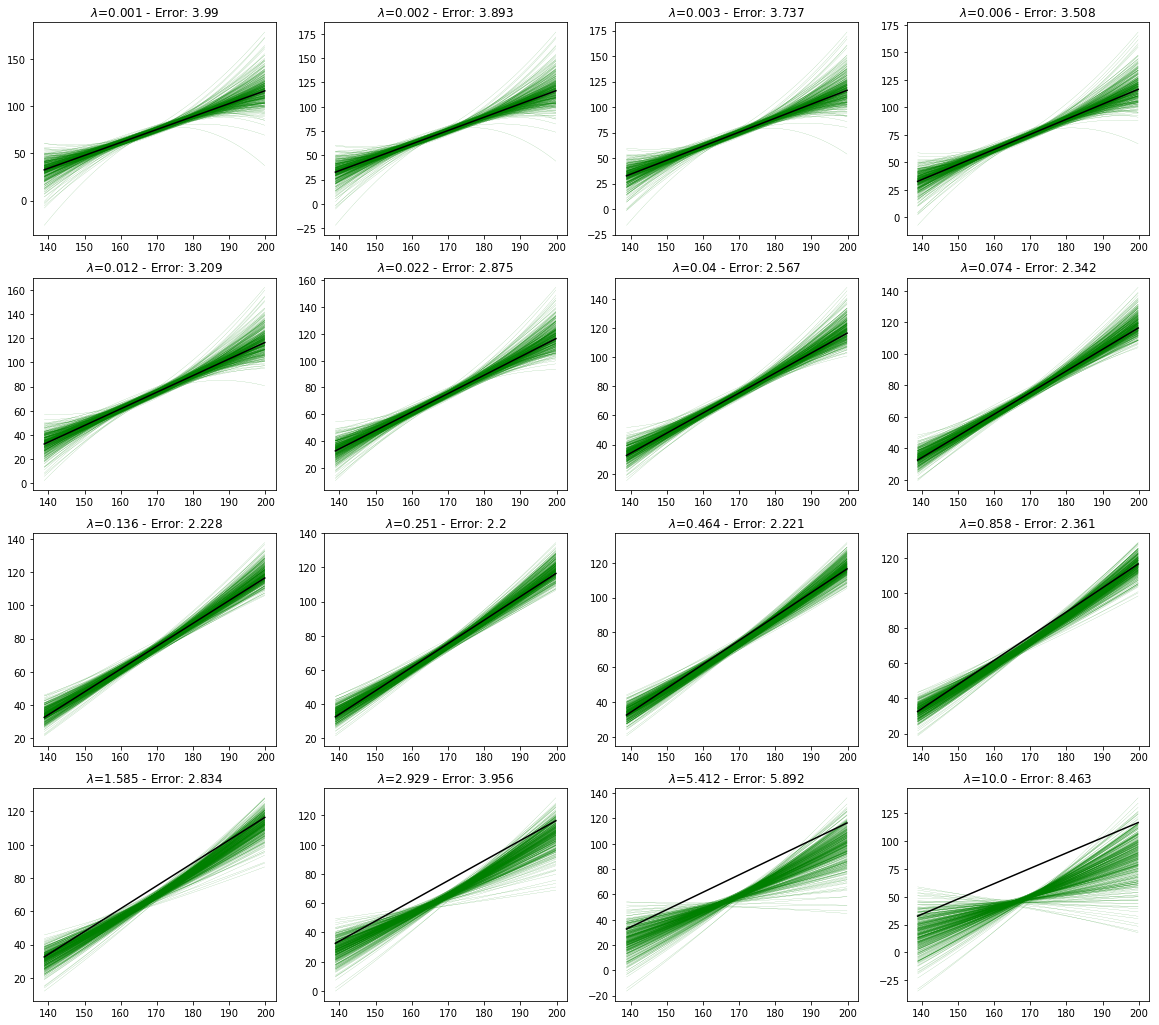

In [22]:
cols = 4
rows = 4
lambdas = np.logspace(-3, 1, cols*rows)
f, ax = plt.subplots(cols,rows, figsize=(20,18))
ax = ax.reshape(-1)
al = np.linspace(data[:,0].min(),data[:,0].max(), ptos)
errors = []
for i,lamb in enumerate(lambdas):    
    curv_MLE, curv_MAP = get_curves(alturas_pol, data[:,0].min(), data[:,0].max(), order = 3, N=20, lamb = lamb)
    error = (curv_MAP.T-pe_LR).std(axis=0).mean()
    errors.append(error)
    ax[i].set_title("$\lambda$=" + str(np.round(lamb*1000)/1000) +" - Error: " + str(str(np.round(error*1000)/1000)))
    ax[i].plot(al, curv_MAP.T, 'g', lw=0.1)
    ax[i].plot(al, pe_LR, 'k', label='Lineal')
plt.show()

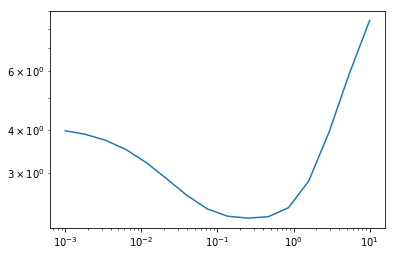

In [23]:
plt.loglog(lambdas, errors)
plt.show()

# LASSO vs RIDGE

## Aca lambda es alpha

In [181]:
from sklearn.linear_model import Lasso, Ridge
alturas_pol, mean, std = get_pol(data[:,0], order, normalize=True)

In [197]:
i_sel = 3
order = 7
al = np.linspace(data[:,0].min(),data[:,0].max(), ptos)
alturas_pol, mean, std = get_pol(data[:,0], order, normalize=True)

In [198]:
alphas = np.logspace(-3, 3, 100)

In [199]:
ws_RIDGE = np.zeros([len(alphas), order+1])
ws_LASSO = np.zeros([len(alphas), order+1])
for i, alpha in enumerate(alphas):
    clf_ridge = Ridge(alpha = alpha, fit_intercept=False)
    clf_ridge.fit(alturas_pol[i_sel*N:(i_sel+1)*N, :], data[:,1][i_sel*N:(i_sel+1)*N])
    w_RIDGE = np.array(list(clf_ridge.coef_))
    w_RIDGE = get_ridge_weights(alturas_pol[i_sel*N:(i_sel+1)*N, :], data[:,1][i_sel*N:(i_sel+1)*N], lamb = alpha).reshape(1,-1)
    clf_lasso = Lasso(alpha = alpha, fit_intercept=False, tol=0.0001, max_iter=100000)
    clf_lasso.fit(alturas_pol[i_sel*N:(i_sel+1)*N, :], data[:,1][i_sel*N:(i_sel+1)*N])
    w_LASSO = np.array(list(clf_lasso.coef_))
    ws_RIDGE[i,:] = w_RIDGE
    ws_LASSO[i,:] = w_LASSO

### Aclaración: No estoy graficando el intercept

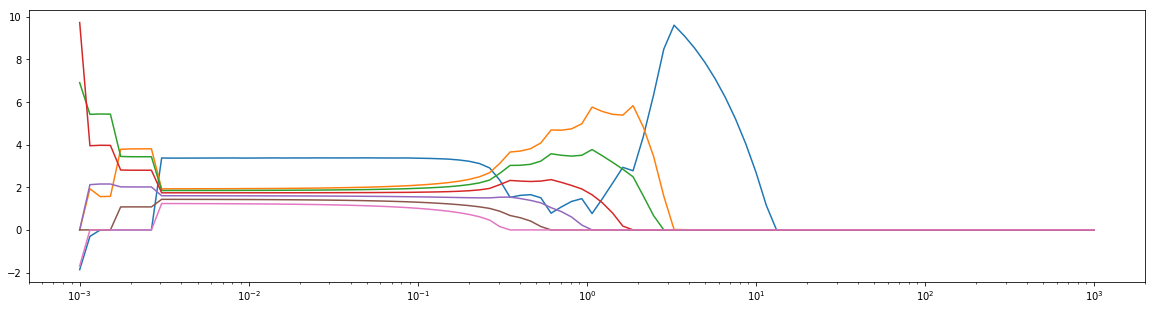

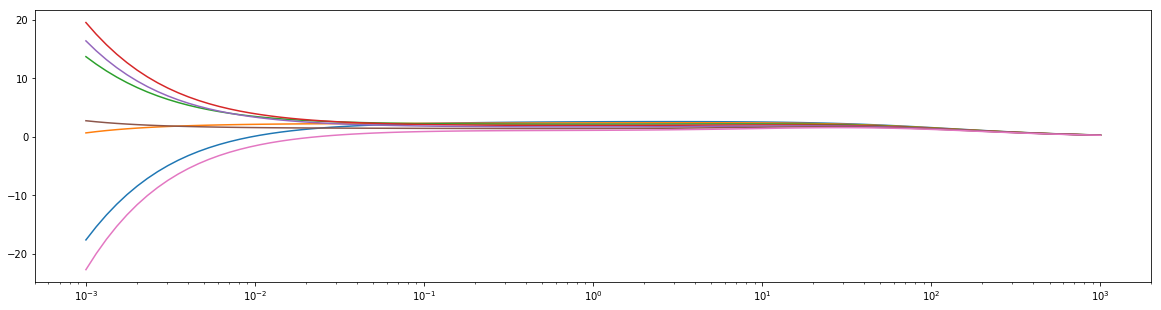

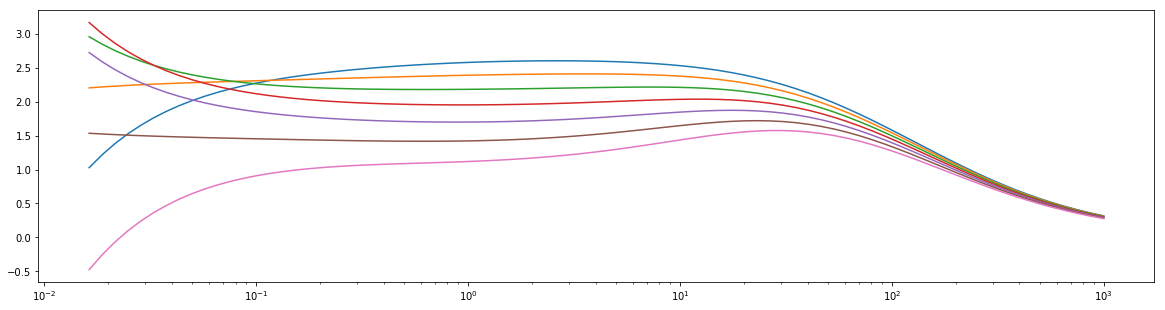

In [216]:
plt.figure(figsize=(20,5))
plt.semilogx(alphas, ws_LASSO[:,1:])
plt.show()

plt.figure(figsize=(20,5))
plt.semilogx(alphas, ws_RIDGE[:,1:])
plt.show()

plt.figure(figsize=(20,5))
plt.semilogx(alphas[20:], ws_RIDGE[20:,1:])
plt.show()

In [201]:
clf = LinearRegression()
clf.fit(data[:,0].reshape(-1,1), data[:,1])
w_LR = np.array([clf.intercept_, clf.coef_[0]]).reshape(2,1)

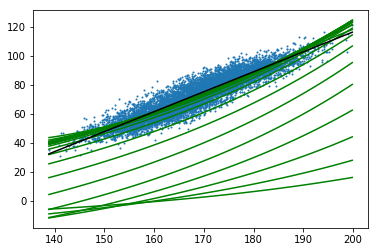

In [210]:
al_line = get_pol(al, normalize=False, order=order, mean=mean, std=std)
for w in ws_RIDGE[::5]:
    pe_RIDGE = al_line.dot(w)
    plt.plot(al, pe_RIDGE, 'g', label='RIDGE')
plt.plot(al, pe_LR, 'k', label='LASSO')
plt.scatter(data[:,0], data[:,1], s=1)
plt.show()

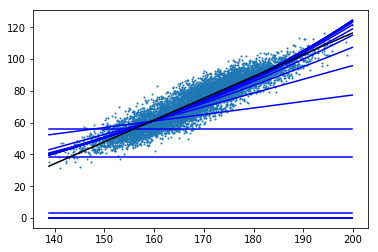

In [211]:
for w in ws_LASSO[::5]:
    pe_LASSO = al_line.dot(w)
    plt.plot(al, pe_LASSO, 'b', label='LASSO')
pe_LR = get_pol(al, normalize=False).dot(w_LR)
plt.plot(al, pe_LR, 'k', label='LASSO')
plt.scatter(data[:,0], data[:,1], s=1)
plt.show()